In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import netCDF4
from matplotlib.ticker import PercentFormatter

In [2]:
data_dir = r'F:\Snow_Drift_Thesis\Data\Meteorological_Data\ERA5'
month_info = ['Jul_Aug', 'Sep_Oct', 'Nov_Dec']

ERA5_dataset = {
    'u10': {
        'name': '10m_u_component_of_wind_stream-oper_daily-mean.nc',
        'dat': None,
        'lat': None,
        'lon': None,
        'time': None
    },
    'v10': {
        'name': '10m_v_component_of_wind_0_daily-mean.nc',
        'dat': None,
        'lat': None,
        'lon': None,
        'time': None
    },
    'csf': {
        'name': 'convective_snowfall_0_daily-mean.nc',
        'dat': None,
        'lat': None,
        'lon': None,
        'time': None
    },
    'lsf': {
        'name': 'large_scale_snowfall_0_daily-mean.nc',
        'dat': None,
        'lat': None,
        'lon': None,
        'time': None
    },
    'sf': {
        'name': 'snowfall_0_daily-mean.nc',
        'dat': None,
        'lat': None,
        'lon': None,
        'time': None
    },
    'tp': {
        'name': 'total_precipitation_0_daily-mean.nc',
        'dat': None,
        'lat': None,
        'lon': None,
        'time': None
    }
}

# file = [month_info[1] + ERA5_dataset['u10']]
# file_dir = os.path.join(data_dir, month_info[1], ERA5_dataset['u10'])

In [3]:
ERA5_dataset.keys()

dict_keys(['u10', 'v10', 'csf', 'lsf', 'sf', 'tp'])

In [4]:
### Read EAR5 daily data

for key in ERA5_dataset.keys():
    data_all = []
    latitude = None
    longitude = []
    time_all = []
    
    for month in month_info:    
        file_name = os.path.join(data_dir, month, ERA5_dataset[key]['name'])
        ds = xr.open_dataset(file_name,engine="netcdf4")
        
        data_array = ds[key].data
        data_all.append(data_array)
        
        time_array = ds['valid_time'].data
        time_all.append(time_array)
        
        if latitude is None:
            latitude_array = ds['latitude'].data
            longitude_array = ds['longitude'].data

    ERA5_dataset[key]['dat'] = np.concatenate(data_all, axis=0)
    ERA5_dataset[key]['time'] = np.concatenate(time_all, axis=0)
    ERA5_dataset[key]['lat'] = latitude_array
    ERA5_dataset[key]['lon'] = longitude_array

        

In [5]:
ERA5_dataset[key]['lat'].shape

(2,)

In [6]:
print(ERA5_dataset['u10'].keys())

dict_keys(['name', 'dat', 'lat', 'lon', 'time'])


In [8]:
### Wind_ERA5

# 1. wind speed calculation
u10_data = ERA5_dataset['u10']['dat'][:,0,1:4]
v10_data = ERA5_dataset['v10']['dat'][:,0,1:4]

wind_speed = np.sqrt(u10_data**2 + v10_data**2)

# 2. wind direction
# math direction
wind_direction_math= np.arctan2(v10_data, u10_data) * 180 / np.pi
# change to meteorological convention
wind_direction = (270 - wind_direction_math) % 360

# 3. area mean and std wind speed 
mean_speed = np.mean(np.array(wind_speed), axis=1)
std_speed= np.std(np.array(wind_speed), axis=1)

# 4. vcector mean wind direction/ directional mean of wind vectors
angles_rad = np.radians(wind_direction)
mean_x = np.mean(np.cos(angles_rad),axis=1)
mean_y = np.mean(np.sin(angles_rad),axis=1)
mean_direction_rad = np.arctan2(mean_y, mean_x)
mean_direction = np.degrees(mean_direction_rad)
mean_direction_correctted = np.where(mean_direction < 0, mean_direction + 360, mean_direction)
confidence = np.sqrt(mean_x**2 + mean_y**2)

In [11]:
mean_direction_correctted.shape

(184,)

In [9]:
mean_direction_correctted[120:127]

array([219.94093 ,  92.83025 ,  95.927864,  95.71801 ,  92.12869 ,
        86.92454 , 104.97189 ], dtype=float32)

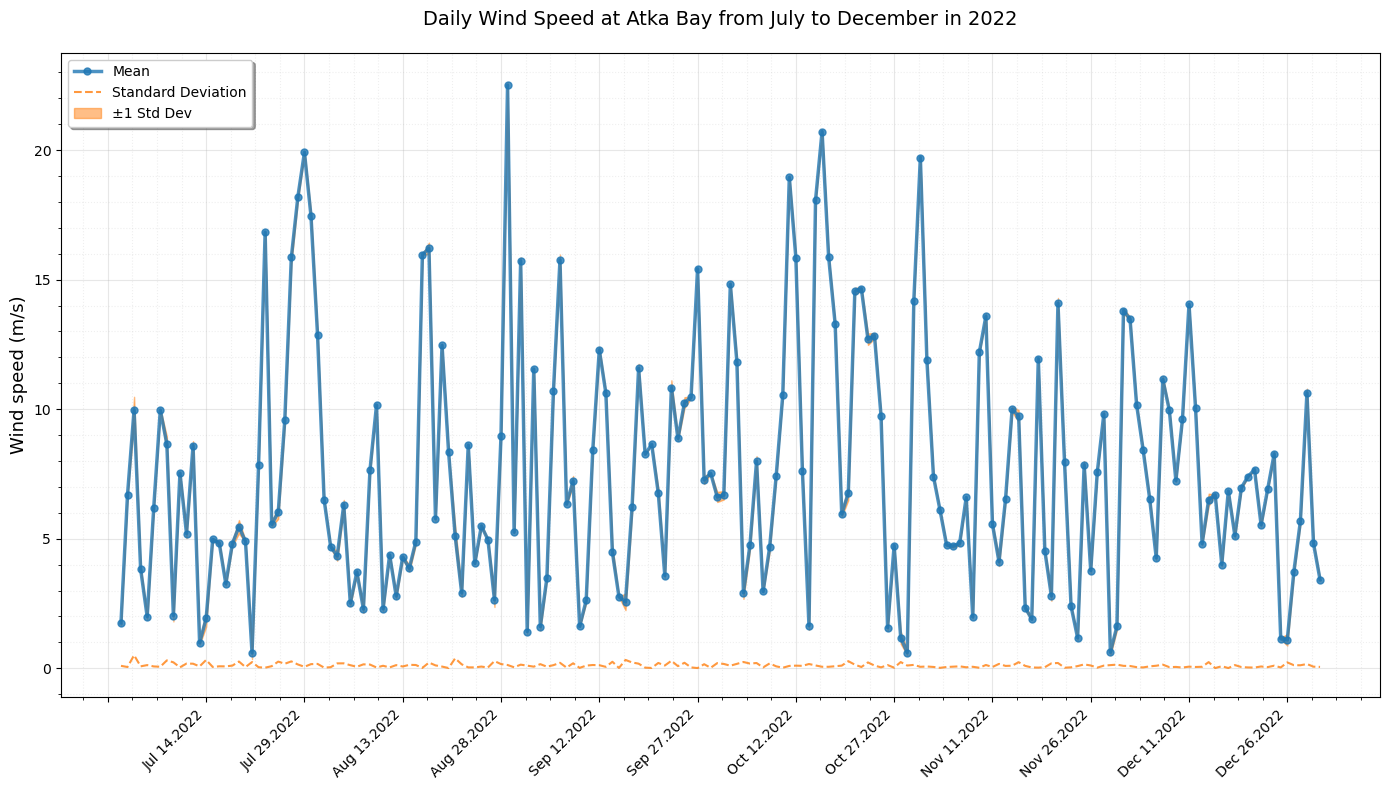

In [15]:
# 5. mean wind speed plot
time = ERA5_dataset['u10']['time']
dates = pd.to_datetime(time)
formatted_dates = [dt.strftime("%b %d.%Y").replace(" 0", " ") for dt in dates]

fig, ax = plt.subplots(1, 1, figsize=(14, 8))

upper_bound = mean_speed + std_speed
lower_bound = mean_speed - std_speed

line_mean = ax.plot(formatted_dates, mean_speed, linewidth=2.5, marker='o', markersize=5, 
               color='#1f77b4', alpha=0.8, label='Mean')
line_std = ax.plot(formatted_dates, std_speed, linewidth=1.5, marker='', markersize=5, 
               color='#ff7f0e', alpha=0.8, linestyle='--', label='Standard Deviation')
ax.fill_between(formatted_dates, lower_bound, upper_bound, 
                color='#ff7f0e', alpha=0.5, label='±1 Std Dev')

ax.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=15)) 
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

ax.set_ylabel('Wind speed (m/s)', fontsize=13)

ax.set_title('Daily Wind Speed at Atka Bay from July to December in 2022', fontsize=14, pad=20)

ax.grid(True, which='major', linestyle='-', alpha=0.3)
ax.grid(True, which='minor', linestyle=':', alpha=0.2)
ax.minorticks_on()

ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
# plt.savefig('time_series.png', dpi=300, bbox_inches='tight')
plt.show()

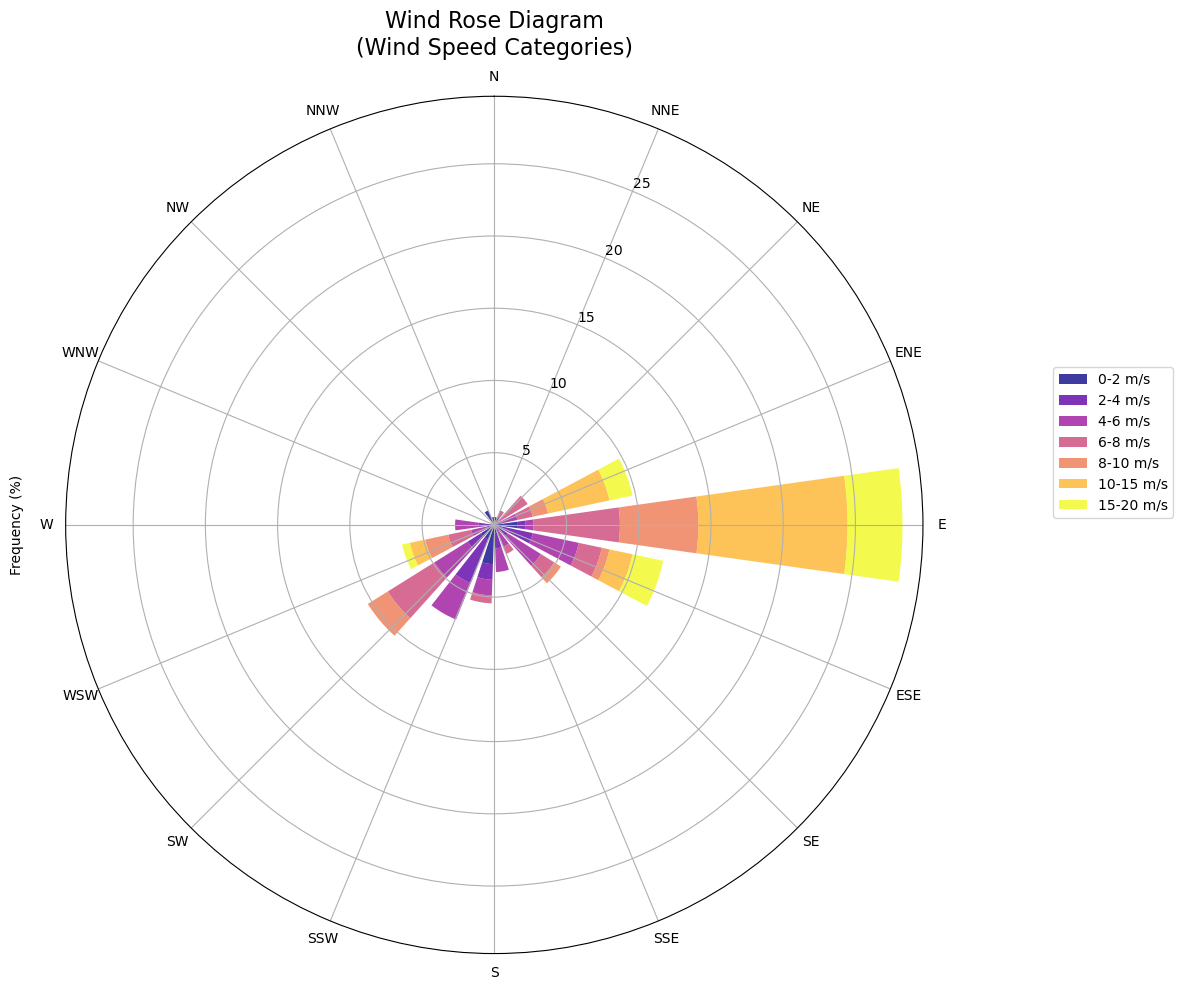

In [10]:
# 6. wind rose plot
def advanced_wind_rose(mean_direction, mean_speed, speed_bins=None):
 
    if speed_bins is None:
        speed_bins = [0, 2, 4, 6, 8, 10, 15, 20]  # wind-speed categories (m/s)
    
  
    num_directions = 18 
    direction_bins = np.linspace(0, 360, num_directions + 1)
    direction_centers = np.linspace(0, 360, num_directions, endpoint=False) + (360/num_directions/2)
    
    # Create a polar subplot
    fig, ax = plt.subplots(1, 1, figsize=(14, 10), subplot_kw=dict(projection='polar'))
    
    # Compute frequencies for each wind-speed category
    colors = plt.cm.plasma(np.linspace(0, 1, len(speed_bins)-1))
    
    bottom_vals = np.zeros(len(direction_centers))
    
    for i in range(len(speed_bins) - 1):
        min_speed = speed_bins[i]
        max_speed = speed_bins[i + 1]
        
        # Select observations within the current speed range
        speed_mask = (mean_speed >= min_speed) & (mean_speed < max_speed)
        
        frequencies = []
        for j in range(len(direction_bins) - 1):
            dir_mask = (mean_direction >= direction_bins[j]) & (mean_direction < direction_bins[j + 1])
            combined_mask = speed_mask & dir_mask
            freq = np.sum(combined_mask) / len(mean_direction) * 100
            frequencies.append(freq)
        
        # Draw stacked bars for this speed category
        theta = np.radians(direction_centers)
        widths = np.radians(360 / num_directions) * 0.8 # a little gap between bars
        
        ax.bar(theta, frequencies, width=widths, bottom=bottom_vals, 
               color=colors[i], alpha=0.8, 
               label=f'{min_speed}-{max_speed} m/s')
        
        bottom_vals += np.array(frequencies)
    
    # Polar axis styling
    ax.set_theta_zero_location('N')  # 0° at the top (North)
    ax.set_theta_direction(-1) # clockwise increasing angles (meteorological)
    
    directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE',
                  'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
    ax.set_thetagrids(np.arange(0, 360, 22.5), directions)
    
    ax.set_title('Wind Rose Diagram\n(Wind Speed Categories)', pad=30, fontsize=16)
    ax.set_ylabel('Frequency (%)', labelpad=30)
    ax.legend(loc='lower right', bbox_to_anchor=(1.3, 0.5))
    
    plt.tight_layout()
    return fig, ax
    

# Example usage
#fig, ax = advanced_wind_rose(mean_direction_correctted, mean_speed)
plt.show()


In [10]:
# 7. Wind field statistics

def wind_statistics_table(mean_direction, mean_speed, num_directions=18):
    """
    生成风场统计信息
    """
    
    # Compute direction bins internally
    direction_bins = np.linspace(0, 360, num_directions + 1)
    direction_centers = np.linspace(0, 360, num_directions, endpoint=False) + (360/num_directions/2)
    
    # Frequency for each direction bin (in percent)
    frequencies = []
    for i in range(len(direction_bins) - 1):
        mask = (mean_direction >= direction_bins[i]) & (mean_direction < direction_bins[i + 1])
        freq = np.sum(mask) / len(mean_direction) * 100  # 转换为百分比
        frequencies.append(freq)
    
    # Direction labels
    if num_directions == 16:
        directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE',
                      'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
    elif num_directions == 8:
        directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
    else:
        directions = [f'{int(center)}°' for center in direction_centers]
    
    # Dominant direction
    dominant_idx = np.argmax(frequencies)
    dominant_direction_deg = direction_centers[dominant_idx]
    dominant_direction_label = directions[dominant_idx]
    
    # Summary statistics
    stats = {
        'Mean Wind Speed (m/s)': np.mean(mean_speed),
        'Max Wind Speed (m/s)': np.max(mean_speed),
        'Min Wind Speed (m/s)': np.min(mean_speed),
        'Std Wind Speed (m/s)': np.std(mean_speed),
        'Dominant Direction (°)': dominant_direction_deg,
        'Dominant Direction': dominant_direction_label,
        'Dominant Direction Frequency (%)': frequencies[dominant_idx],
        'Calm Conditions (<1m/s) (%)': np.sum(mean_speed < 1) / len(mean_speed) * 100
    }
    
    print("=== Wind Statistics ===")
    for key, value in stats.items():
        if isinstance(value, float):
            print(f"{key}: {value:.2f}")
        else:
            print(f"{key}: {value}")
    
    # Print a readable summary
    print(f"\n=== Additional Info ===")
    print(f"Total Data Points: {len(mean_speed)}")
    print(f"Wind Speed Range: {np.min(mean_speed):.2f} - {np.max(mean_speed):.2f} m/s")
     
    return stats, frequencies, direction_centers, directions

# Example usage:
stats, frequencies, direction_centers, directions = wind_statistics_table(mean_direction, mean_speed)


=== Wind Statistics ===
Mean Wind Speed (m/s): 7.596151828765869
Max Wind Speed (m/s): 22.50487518310547
Min Wind Speed (m/s): 0.5919793248176575
Std Wind Speed (m/s): 4.734491348266602
Dominant Direction (°): 90.00
Dominant Direction: 90°
Dominant Direction Frequency (%): 28.80
Calm Conditions (<1m/s) (%): 2.17

=== Additional Info ===
Total Data Points: 184
Wind Speed Range: 0.59 - 22.50 m/s


In [ ]:
# Daily snowfall and precipitation_ERA5

  #large-scale snowfall: m of water equivalent
  #convective snowfall: m of water equivalent
  #snowfall: m of water equivalent
  #total precipitation: m
lsf_data = ERA5_dataset['lsf']['dat'][:,0,1:4]
csf_data = ERA5_dataset['csf']['dat'][:,0,1:4]
sf_data = ERA5_dataset['sf']['dat'][:,0,1:4]
tp_data = ERA5_dataset['tp']['dat'][:,0,1:4]

mean_lsf = np.mean(np.array(lsf_data), axis=1)
mean_csf = np.mean(np.array(csf_data), axis=1)
mean_sf = np.mean(np.array(sf_data), axis=1)
mean_tp = np.mean(np.array(tp_data), axis=1)

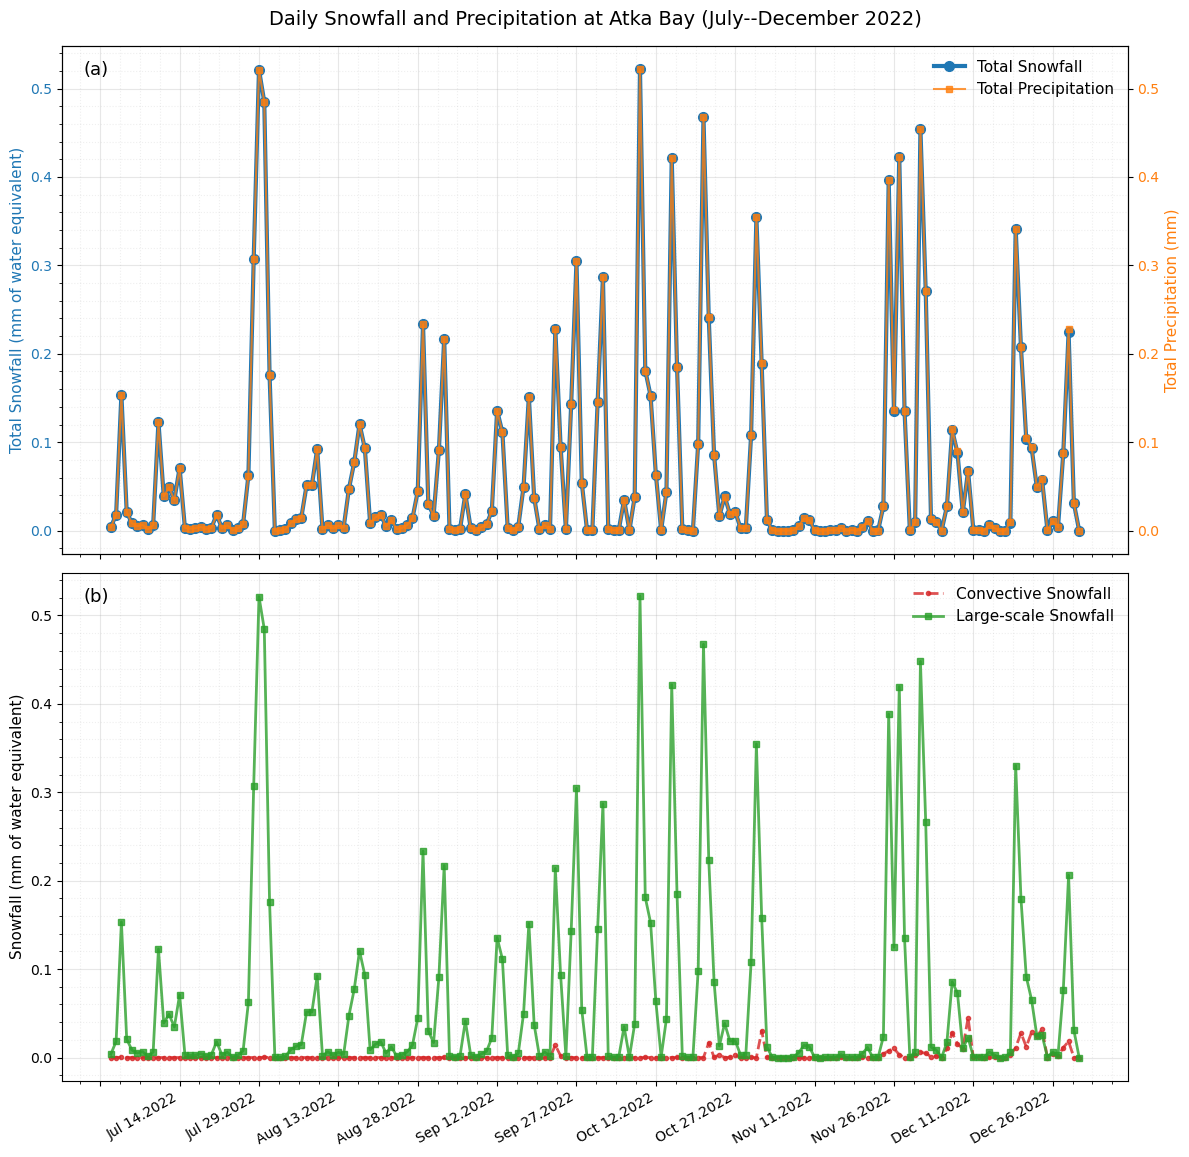

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# total snowfall and total precipitation
ax1.plot(formatted_dates, mean_sf*1000, linewidth=3, marker='o', markersize=7, 
         color='#1f77b4', alpha=1, label='Total Snowfall')
ax1_twin = ax1.twinx()
ax1_twin.plot(formatted_dates, mean_tp*1000, linewidth=1.5, marker='s', markersize=4, 
              color='#ff7f0e', alpha=0.8, label='Total Precipitation')

ax1.set_ylabel('Total Snowfall (mm of water equivalent)', color='#1f77b4', fontsize=11)
ax1_twin.set_ylabel('Total Precipitation (mm)', color='#ff7f0e', fontsize=11)
ax1.tick_params(axis='y', labelcolor='#1f77b4')
ax1_twin.tick_params(axis='y', labelcolor='#ff7f0e')


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right',frameon=False, fontsize=11)

ax1.grid(True, which='major', linestyle='-', alpha=0.3)
ax1.grid(True, which='minor', linestyle=':', alpha=0.2)
ax1.minorticks_on()

# convective snowfall and large scale snow fall
ax2.plot(formatted_dates, mean_csf*1000, linewidth=2, marker='o', markersize=3, 
         color='#d62728', linestyle='--', alpha=0.8, label='Convective Snowfall')
ax2.plot(formatted_dates, mean_lsf*1000, linewidth=2, marker='s', markersize=5, 
         color='#2ca02c', alpha=0.8, label='Large-scale Snowfall')

ax2.set_ylabel('Snowfall (mm of water equivalent)',fontsize=11)
ax2.legend(loc='upper right', frameon=False, fontsize=11)

ax2.grid(True, which='major', linestyle='-', alpha=0.3)
ax2.grid(True, which='minor', linestyle=':', alpha=0.2)
ax2.minorticks_on()


ax2.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=15)) 
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=30, ha='right')

title_style = {
    'fontsize': 13,
    'verticalalignment': 'top',
    'horizontalalignment': 'left',   
}

ax1.text(0.02, 0.97, '(a)',
         transform=ax1.transAxes,
         **title_style)

ax2.text(0.02, 0.97, '(b)',
         transform=ax2.transAxes,
         **title_style)

fig.suptitle('Daily Snowfall and Precipitation at Atka Bay (July--December 2022)', fontsize=14, y=0.96)

plt.tight_layout()
plt.subplots_adjust(top=0.93)

# plt.savefig('daily_snowfall_precipitation.png', dpi=300, bbox_inches='tight')
plt.show()
    
    



In [16]:
# Tempereature_ERA5
t2m_era5 = xr.open_dataset(r"F:\Snow_Drift_Thesis\Data\Meteorological_Data\ERA5\Temperature.nc",engine="netcdf4")
print(t2m_era5)
print(t2m_era5.variables.keys()) 
t2m_era5_data = (t2m_era5['t2m'].data- 273.15)[:,0,1:4]
t2m_era5_mean = np.mean(np.array(t2m_era5_data), axis=1)

<xarray.Dataset> Size: 9kB
Dimensions:     (valid_time: 184, latitude: 2, longitude: 5)
Coordinates:
    number      int64 8B ...
  * latitude    (latitude) float64 16B -70.55 -70.8
  * longitude   (longitude) float64 40B -8.3 -8.05 -7.8 -7.55 -7.3
  * valid_time  (valid_time) datetime64[ns] 1kB 2022-07-01 ... 2022-12-31
Data variables:
    t2m         (valid_time, latitude, longitude) float32 7kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-14T14:49 GRIB to CDM+CF via cfgrib-0.9.1...
KeysView(Frozen({'t2m': <xarray.Variable (valid_time: 184, latitude: 2, longitude: 5)> Size: 7kB
[1840 values with dtype=float32]
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                       

In [17]:
# Temperature_Wind_NM

import pandas as pd
import glob, os, re
folder_path = r"F:\Snow_Drift_Thesis\Data\Meteorological_Data\NM3"   

all_files = glob.glob(os.path.join(folder_path, "*.tab"))

def make_unique(cols):
    """Change duplicate column names to unique ones: keep the original name for the first time, and then add __2,__3..."""
    seen = {}
    out = []
    for c in cols:
        k = re.sub(r"\s+", " ", str(c)).strip()  # normalize whitespace
        if k in seen:
            seen[k] += 1
            out.append(f"{k}__{seen[k]}")
        else:
            seen[k] = 1
            out.append(k)
    return out

def read_gvn_tab(path):
    # 1) Find the actual header row: usually starts with "Date/Time"
    header_idx = None
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(f):
            if line.strip().startswith("Date/Time"):
                header_idx = i
                break
    if header_idx is None:
        raise RuntimeError(f"no header（Date/Time）: {path}")

    # 2) Start reading from the header row; let pandas handle duplicate column names (read them in first), 
    # then manually change them to unique
    df = pd.read_csv(
        path,
        sep="\t",
        engine="python",
        skiprows=range(header_idx),  # Skip comments and instructions
        header=0,                    # Use the "Date/Time ..." line as the table header
        on_bad_lines="warn",         # Warn and skip bad lines
        encoding="utf-8",
    )

    # 3) Unify and remove duplicate listings
    df.columns = make_unique(df.columns)

    return df

dfs = []
for file in all_files:
    fname = os.path.basename(file)
    m = re.search(r"(\d{4})-(\d{2})", fname)
    year, month = (m.group(1), m.group(2)) if m else (None, None)

    df = read_gvn_tab(file)
    df["source_file"] = fname
    df["year"] = year
    df["month"] = month
    if year and month:
        df["date"] = pd.to_datetime(f"{year}-{month}-01")

    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)


In [18]:
keep_idx = [0, 4, 5]  # date, 10m wind speed, 2m temperature
df_sub = df_all.iloc[:, keep_idx].copy()

# Convert the first column to actual datetime
tcol = df_sub.columns[0]
df_sub[tcol] = pd.to_datetime(df_sub[tcol], errors="coerce")
df_sub = df_sub.dropna(subset=[tcol])  # Drop rows where datetime parsing failed

#  Compute daily means (numeric columns only)
daily_mean = (
    df_sub
    .set_index(tcol)
    .resample("D")                    # Resample at daily frequency
    .mean(numeric_only=True)          # Take mean over numeric columns only
    .reset_index()
    .rename(columns={tcol: "date"})   # Rename the datetime column to 'date'
)

print(daily_mean.head())
wind_speed_NM= daily_mean.iloc[:, 1]
t2m_NM= daily_mean.iloc[:, -1]

        date  FF10 [m/s] (1-min average)  T2 [°C] (1-min average)
0 2022-07-01                    4.134792               -40.211389
1 2022-07-02                    5.171319               -34.012708
2 2022-07-03                   13.963472               -15.977847
3 2022-07-04                    4.985972               -22.457014
4 2022-07-05                    2.882083               -26.661042


In [19]:
avg_t2m_er5 = np.mean(t2m_era5_mean)
max_t2m_er5 = np.max(t2m_era5_mean)
min_t2m_er5 = np.min(t2m_era5_mean)
print(f'mean temperature:{avg_t2m_er5}')
print(f'max temperature:{max_t2m_er5}')
print(f'min temperature:{min_t2m_er5}')
max_er5_id = np.where(t2m_era5_mean == max_t2m_er5)[0][0]
date_era5 = formatted_dates[max_er5_id]
print(date_era5)


avg_t2m_nm = np.mean(t2m_NM)
max_t2m_nm = np.max(t2m_NM)
min_t2m_nm = np.min(t2m_NM)
print(f'mean temperature:{avg_t2m_nm}')
print(f'max temperature:{max_t2m_nm}')
print(f'min temperature:{min_t2m_nm}')
max_nm_id = np.where(t2m_NM == max_t2m_nm)[0][0]
date_nm = formatted_dates[max_nm_id]
print(date_nm)
print(formatted_dates[np.where(t2m_era5_mean == np.min(t2m_era5_mean))[0][0]])
print(formatted_dates[np.where(t2m_NM == np.min(t2m_NM))[0][0]])

mean temperature:-14.50837230682373
max temperature:-0.6218363642692566
min temperature:-29.67413902282715
Dec 30.2022
mean temperature:-17.689542727474016
max temperature:-1.2165846802529867
min temperature:-40.21138888888889
Dec 30.2022
Jul 17.2022
Jul 1.2022


In [20]:
print(formatted_dates[np.where(mean_speed == np.max(mean_speed))[0][0]])
print(formatted_dates[np.where(wind_speed_NM == np.max(wind_speed_NM))[0][0]])
print(formatted_dates[np.where(mean_speed == np.min(mean_speed))[0][0]])
print(formatted_dates[np.where(wind_speed_NM == np.min(wind_speed_NM))[0][0]])

Aug 29.2022
Aug 29.2022
Jul 21.2022
Jul 21.2022


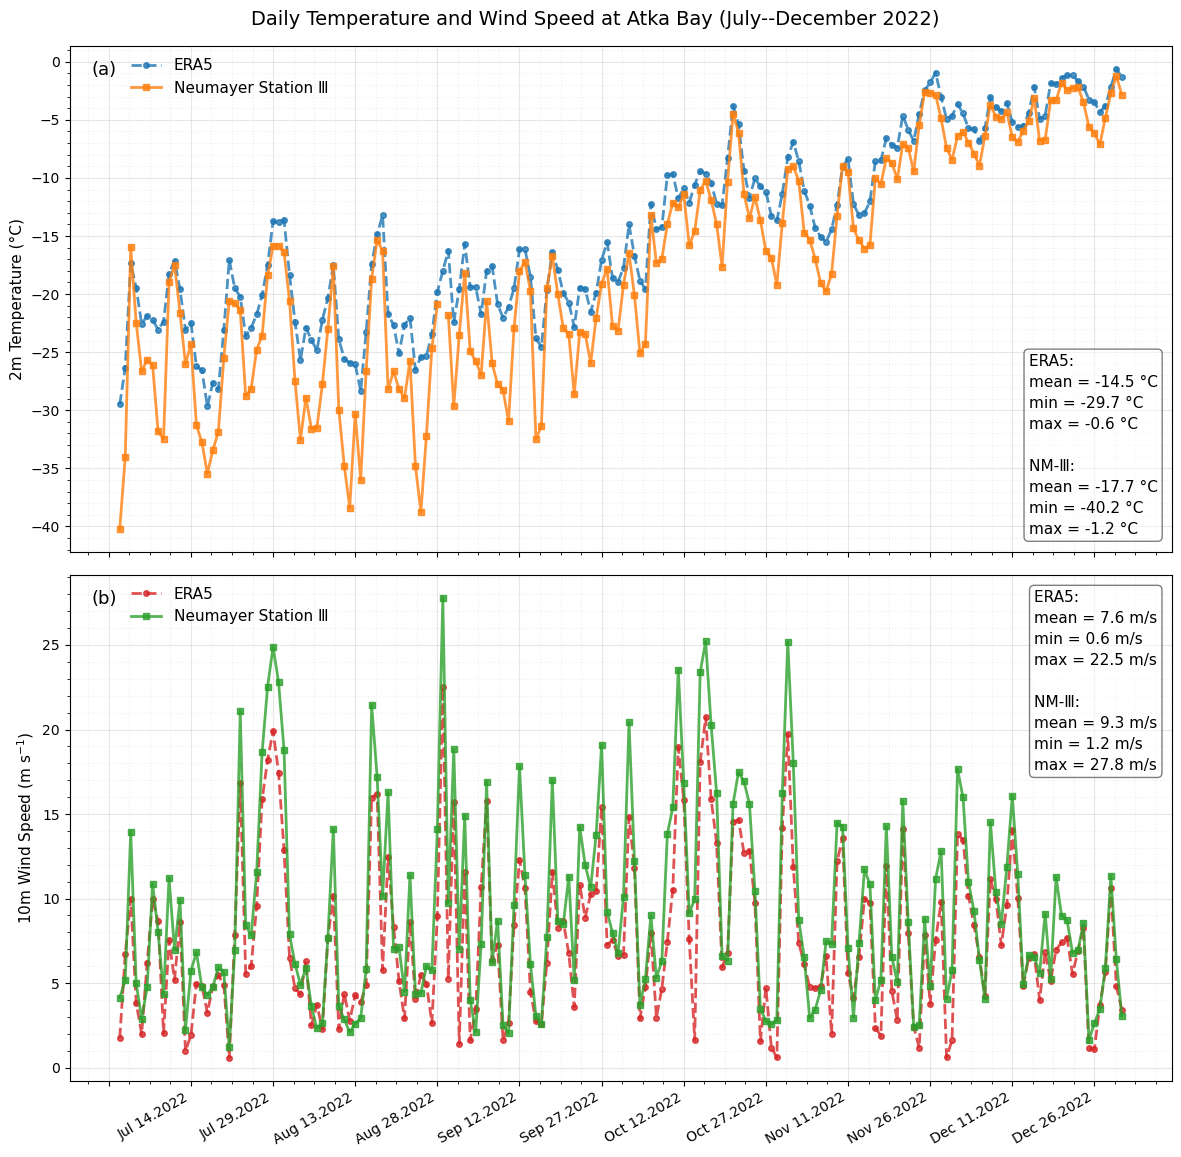

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# temperature ERA5 & NM
ax1.plot(formatted_dates, t2m_era5_mean, linewidth=2, marker='o', markersize=4, 
         color='#1f77b4', linestyle='--', alpha=0.8, label='ERA5')
ax1.plot(formatted_dates, t2m_NM, linewidth=2, marker='s', markersize=4, 
              color='#ff7f0e', alpha=0.8, label='Neumayer Station Ⅲ')

ax1.set_ylabel('2m Temperature (°C)', fontsize=11)


# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(loc=(0.05, 0.89), frameon=False, fontsize=11)

ax1.grid(True, which='major', linestyle='-', alpha=0.3)
ax1.grid(True, which='minor', linestyle=':', alpha=0.2)
ax1.minorticks_on()

# Add statistic summary
txtA = (f"ERA5: \n"
        f"mean = {np.mean(t2m_era5_mean):.1f} °C\n"
        f"min = {np.min(t2m_era5_mean):.1f} °C\n"
        f"max = {np.max(t2m_era5_mean):.1f} °C\n"
        f"\n"
        f"NM-Ⅲ: \n"
        f"mean = {np.mean(t2m_NM):.1f} °C\n"
        f"min = {np.min(t2m_NM):.1f} °C\n"
        f"max = {np.max(t2m_NM):.1f} °C")

ax1.text(0.87, 0.03, txtA,
         transform=ax1.transAxes,
         fontsize=11,
         verticalalignment='bottom',
         horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.5),
         linespacing=1.5)



# wind speed ERA5 & NM
ax2.plot(formatted_dates, mean_speed, linewidth=2, marker='o', markersize=4, 
         color='#d62728', linestyle='--', alpha=0.8, label='ERA5')
ax2.plot(formatted_dates, wind_speed_NM, linewidth=2, marker='s', markersize=4, 
         color='#2ca02c', alpha=0.8, label='Neumayer Station Ⅲ')

ax2.set_ylabel('10m Wind Speed (m s$^{-1}$)',fontsize=11)
ax2.legend(loc=(0.05, 0.89), frameon=False, fontsize=11)

ax2.grid(True, which='major', linestyle='-', alpha=0.3)
ax2.grid(True, which='minor', linestyle=':', alpha=0.2)
ax2.minorticks_on()

# Add statistic summary
txtB = (f"ERA5: \n"
        f"mean = {np.mean(mean_speed):.1f} m/s\n"
        f"min = {np.min(mean_speed):.1f} m/s\n"
        f"max = {np.max(mean_speed):.1f} m/s\n"
        f"\n"
        f"NM-Ⅲ: \n"
        f"mean = {np.mean(wind_speed_NM):.1f} m/s\n"
        f"min = {np.min(wind_speed_NM):.1f} m/s\n"
        f"max = {np.max(wind_speed_NM):.1f} m/s")

ax2.text(0.875, 0.97, txtB,
         transform=ax2.transAxes,
         fontsize=11,
         verticalalignment='top',
         horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.5),
         linespacing=1.5)


ax2.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=15)) 
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=30, ha='right')

title_style = {
    'fontsize': 13,
    'verticalalignment': 'top',
    'horizontalalignment': 'left',   
}

ax1.text(0.02, 0.97, '(a)',
         transform=ax1.transAxes,
         **title_style)

ax2.text(0.02, 0.97, '(b)',
         transform=ax2.transAxes,
         **title_style)

fig.suptitle('Daily Temperature and Wind Speed at Atka Bay (July--December 2022)', fontsize=14, y=0.96)

plt.tight_layout()
plt.subplots_adjust(top=0.93)

# plt.savefig('2.2_daily_temperature_windspeed.png', dpi=300, bbox_inches='tight')
plt.show()
    
  


In [22]:
keep_idx2 = [0, 3, 4] # date, 10m wind direction, 10m speed
df_sub2 = df_all.iloc[:, keep_idx2].copy()

# Convert the first column to actual datetime
tcol = df_sub2.columns[0]
df_sub2[tcol] = pd.to_datetime(df_sub2[tcol], errors="coerce")
df_sub2 = df_sub2.dropna(subset=[tcol])  # Drop rows where datetime parsing failed

In [23]:
def vecmean_dir(df, time_col, dir_col, spd_col=None, power=1, calm_thresh=None):
    d = df[[time_col, dir_col] + ([spd_col] if spd_col else [])].copy()
    d[time_col] = pd.to_datetime(d[time_col], errors="coerce")
    d[dir_col]  = pd.to_numeric(d[dir_col], errors="coerce") % 360
    if spd_col:
        d[spd_col] = pd.to_numeric(d[spd_col], errors="coerce").clip(lower=0)

    d = d.dropna(subset=[time_col, dir_col])

    # Optional: remove very weak winds to reduce noise）
    if calm_thresh is not None and spd_col:
        d = d[d[spd_col] >= calm_thresh]

    rad = np.deg2rad(d[dir_col])
    if spd_col:
        w = d[spd_col]**power            # # power=1 → speed-weighted; try 2 or 3 for sensitivity
    else:
        w = 1.0                          # unweighted
    u = -w * np.sin(rad)                 # # Convert FROM-direction to vector components (east/north positive)
    v = -w * np.cos(rad)

    d["date"] = d[time_col].dt.floor("D")
    uv = pd.DataFrame({"u": u, "v": v, "date": d["date"]}).groupby("date").mean()

    # Back to FROM-direction (0° = North, clockwise)
    dir_from = (np.degrees(np.arctan2(-uv["u"], -uv["v"])) + 360) % 360
    # Resultant length: normalize by mean weight if weighted; otherwise magnitude of (u,v)
    R = np.sqrt(uv["u"]**2 + uv["v"]**2) / (w.groupby(d["date"]).mean()) if spd_col else np.sqrt(uv["u"]**2 + uv["v"]**2)
    return pd.DataFrame({"date": uv.index, "dir_deg": dir_from.values, "resultant": R.values})

def ang_diff(a, b):
    """Angular difference in degrees within [0, 180]"""
    d = (a - b + 180) % 360 - 180
    return np.abs(d)

# Unweighted (each minute has equal weight)）
daily_unw = vecmean_dir(df_sub2, time_col="Date/Time", dir_col="DD10 [deg] (1-min average)")

# Speed-weighted (if FF10 is available)
try:
    daily_w = vecmean_dir(df_sub2, time_col="Date/Time",
                          dir_col="DD10 [deg] (1-min average)",
                          spd_col="FF10 [m/s] (1-min average)",
                          power=1)  
except KeyError:
    daily_w = None


In [24]:
# Compare angular differences
R_TH = 0.8
D_TH = 10  #  Maximum acceptable difference (degrees) between unweighted and weighted means

# Use only resultant length R to identify days where weighting may be unnecessary
ok_by_R = daily_unw[daily_unw["resultant"] >= R_TH]
print(f"days with R ≥ {R_TH} :{len(ok_by_R)} ")

cmp = daily_unw.merge(daily_w, on="date", suffixes=("_unw","_w"))
cmp["delta_deg"] = ang_diff(cmp["dir_deg_unw"], cmp["dir_deg_w"])
ok_by_both = cmp[(cmp["resultant_unw"] >= R_TH) & (cmp["delta_deg"] <= D_TH)]
print(f"Number of days R ≥{R_TH} and diff ≤{D_TH}°：{len(ok_by_both)} / {len(cmp)}")



days with R ≥ 0.8 :141 
Number of days R ≥0.8 and diff ≤10°：140 / 184


In [25]:
mask_stable = (cmp["resultant_unw"] >= R_TH) & (cmp["delta_deg"] <= D_TH)

out = pd.DataFrame({
    "date": cmp["date"],
    "dir_deg_final": np.where(mask_stable, cmp["dir_deg_unw"], cmp["dir_deg_w"]),
    "method": np.where(mask_stable, "unweighted", "speed-weighted"),
    "resultant_unw": cmp["resultant_unw"],
    "delta_deg": cmp["delta_deg"]
})


print(out["method"].value_counts())

method
unweighted        140
speed-weighted     44
Name: count, dtype: int64


In [26]:
direction_vecmean_NM = out.iloc[:, 1]
direction_vecmean_NM

0      187.576438
1      116.649530
2      119.879751
3      198.985106
4      221.339773
          ...    
179    133.606227
180    136.862138
181     95.794061
182     97.168338
183    217.003101
Name: dir_deg_final, Length: 184, dtype: float64

In [27]:
stats1, frequencies1, direction_centers1, directions1 = wind_statistics_table(direction_vecmean_NM, wind_speed_NM)

=== Wind Statistics ===
Mean Wind Speed (m/s): 9.33
Max Wind Speed (m/s): 27.80
Min Wind Speed (m/s): 1.21
Std Wind Speed (m/s): 5.82
Dominant Direction (°): 90.00
Dominant Direction: 90°
Dominant Direction Frequency (%): 37.50
Calm Conditions (<1m/s) (%): 0.00

=== Additional Info ===
Total Data Points: 184
Wind Speed Range: 1.21 - 27.80 m/s


In [28]:
a = wind_speed_NM.to_numpy()
count_a = np.sum((a >= 6) & (a <= 12))
print(count_a)

72


In [29]:
b = mean_speed
count_b = np.sum((b >= 6) & (b <= 12))
print(count_b)

72


In [30]:
direction_vecmean_NM[120:127]

120    161.416636
121     93.048656
122     95.119887
123     99.677720
124     90.811549
125     92.550615
126    126.136119
Name: dir_deg_final, dtype: float64

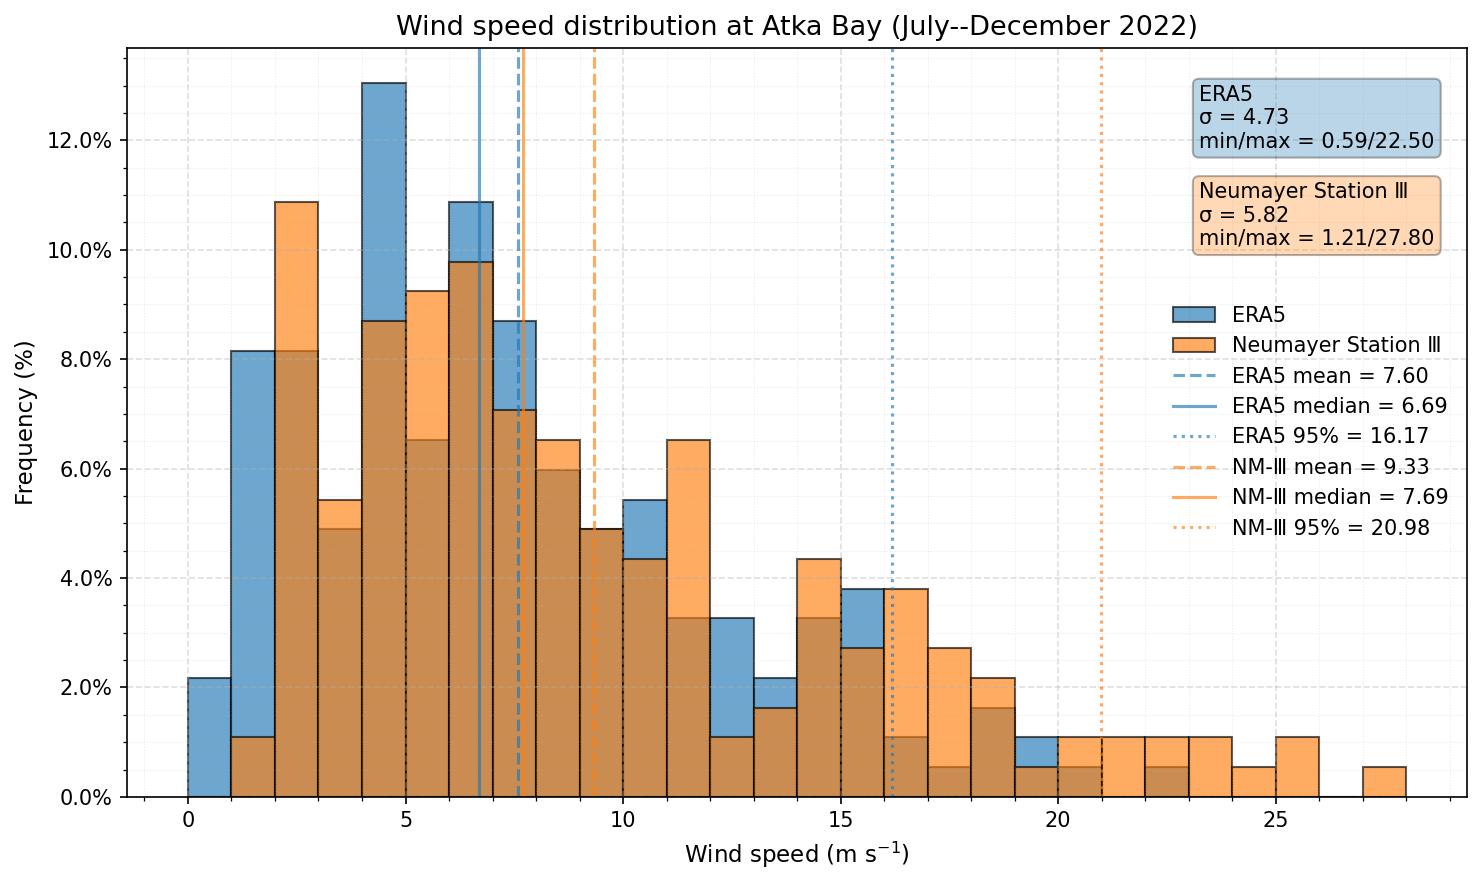

In [37]:

# ===== nput: two datasets =====

labelA, labelB = "ERA5", "Neumayer Station Ⅲ"
sA = mean_speed
sB = wind_speed_NM.to_numpy()

# Unify bins (use combined range of both datasets; FD rule is more robust if you choose to switch)
hi = int(np.ceil(np.nanmax([sA.max(), sB.max()])))  # Round up the upper bound to include the max
bins = np.arange(0, hi + 1, 1) 

# Whether to normalize each dataset to 100% separately (True),
# or normalize by the combined sample size (False)
normalize_each = True
wA = np.ones_like(sA) * 100.0 / (len(sA) if normalize_each else len(allv))
wB = np.ones_like(sB) * 100.0 / (len(sB) if normalize_each else len(allv))

# Summary stats
def stats(x):
    return {
        "n": len(x),
        "mu": x.mean(),
        "med": np.median(x),
        "p95": np.percentile(x, 95),
        "std": x.std(),
        "min": x.min(),
        "max": x.max(),
    }

stA, stB = stats(sA), stats(sB)

# ===== Plotting =====
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

# Histograms (percent)
_, _, patchesA = ax.hist(sA, bins=bins, weights=wA, alpha=0.65, edgecolor="black", label=labelA)
_, _, patchesB = ax.hist(sB, bins=bins, weights=wB, alpha=0.65, edgecolor="black", label=labelB)

# Match reference-line colors to each histogram
colA = patchesA[0].get_facecolor() if len(patchesA) else None
colB = patchesB[0].get_facecolor() if len(patchesB) else None

# Reference lines: mean/median/95th percentile (three per dataset)
ax.axvline(stA["mu"],  linestyle="--", linewidth=1.5, color=colA, label=f"{labelA} mean = {stA['mu']:.2f}")
ax.axvline(stA["med"], linestyle="-",  linewidth=1.5, color=colA, label=f"{labelA} median = {stA['med']:.2f}")
ax.axvline(stA["p95"], linestyle=":",  linewidth=1.5, color=colA, label=f"{labelA} 95% = {stA['p95']:.2f}")

ax.axvline(stB["mu"],  linestyle="--", linewidth=1.5, color=colB, label=f"NM-Ⅲ mean = {stB['mu']:.2f}")
ax.axvline(stB["med"], linestyle="-",  linewidth=1.5, color=colB, label=f"NM-Ⅲ median = {stB['med']:.2f}")
ax.axvline(stB["p95"], linestyle=":",  linewidth=1.5, color=colB, label=f"NM-Ⅲ 95% = {stB['p95']:.2f}")

# Axes / title
ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))
ax.set_xlabel("Wind speed (m s$^{-1}$)",fontsize=11)
ax.set_ylabel("Frequency (%)", fontsize=11)
ax.set_title("Wind speed distribution at Atka Bay (July--December 2022)", fontsize=13)

# Corner info boxes (one for each dataset)
txtA = (f"{labelA}\n"
        f"σ = {stA['std']:.2f}\n"
        f"min/max = {stA['min']:.2f}/{stA['max']:.2f}")
txtB = (f"{labelB}\n"
        f"σ = {stB['std']:.2f}\n"
        f"min/max = {stB['min']:.2f}/{stB['max']:.2f}")

ax.text(0.8, 0.82, txtB, transform=ax.transAxes, ha="left",  va="top",
        bbox=dict(boxstyle="round",facecolor=colB, alpha=0.3))
ax.text(0.8, 0.95, txtA, transform=ax.transAxes, ha="left", va="top",
        bbox=dict(boxstyle="round",facecolor=colA, alpha=0.3))

# Grid & legend
ax.grid(True, which="major", linestyle="--", linewidth=0.8, alpha=0.4)
ax.minorticks_on()
ax.grid(True, which="minor", linestyle=":", linewidth=0.5, alpha=0.25)
ax.legend(ncols=1, frameon=True, framealpha=0.0)
fig.tight_layout()

# Export
# fig.savefig("wind_speed_distribution.png", dpi=300, bbox_inches="tight")

plt.show()

In [40]:
def _clean_series(x):
    s = pd.to_numeric(pd.Series(x).ravel(), errors="coerce")
    return s

def _wind_rose_freqs(direction_deg, speed, speed_bins, num_dirs=18):
    d = _clean_series(direction_deg) % 360
    v = _clean_series(speed)
    n = min(len(d), len(v))
    d, v = d[:n], v[:n]

    dir_edges   = np.linspace(0, 360, num_dirs + 1)
    dir_centers = np.linspace(0, 360, num_dirs, endpoint=False) + (360/num_dirs/2)

    nb = len(speed_bins) - 1
    speed_idx = np.digitize(v, speed_bins, right=False) - 1
    speed_idx = np.clip(speed_idx, 0, nb-1)

    dir_idx = np.digitize(d, dir_edges, right=False) - 1
    dir_idx[dir_idx == num_dirs] = 0

    freq = np.zeros((nb, num_dirs), dtype=float)
    for si in range(nb):
        mask_s = (speed_idx == si)
        if mask_s.any():
            counts, _ = np.histogram(d[mask_s], bins=dir_edges)
            freq[si, :] = counts / n * 100.0
    return freq, dir_centers

# ---------- Draw a single wind rose on a polar axes ----------
def _plot_wind_rose_on_ax(ax, freq, dir_centers, speed_bins,
                          cmap="plasma", width_scale=0.9,
                          title=None, fs_dir=18, fs_r=18, fs_subtitle=20):
    nb, num_dirs = freq.shape
    theta  = np.radians(dir_centers)
    widths = np.radians(360/num_dirs) * width_scale
    colors = plt.get_cmap(cmap)(np.linspace(0, 1, nb))

    bottom = np.zeros(num_dirs)
    handles, labels = [], []
    for i in range(nb):
        bars = ax.bar(theta, freq[i], width=widths, bottom=bottom,
                      color=colors[i], edgecolor="black", linewidth=0.6, alpha=0.9)
        bottom += freq[i]
        labels.append(f"{speed_bins[i]}–{speed_bins[i+1]} m/s" if i < nb-1 else f">={speed_bins[i]} m/s")
        handles.append(bars[0])

    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    dirs = ['N','NNE','NE','ENE','E','ESE','SE','SSE',
            'S','SSW','SW','WSW','W','WNW','NW','NNW']
    ax.set_thetagrids(np.arange(0, 360, 360/16), dirs, fontsize=fs_dir)
    ax.set_rlabel_position(45)
    ax.set_ylabel("Frequency (%)", labelpad=30, fontsize=fs_r)
    if title:
        ax.set_title(title, pad=22, fontsize=fs_subtitle)
    ax.grid(True, alpha=0.35, linestyle="--", linewidth=0.9)
    return handles, labels

# ---------- ide-by-side comparison of two sources + shared legend ----------
def compare_wind_roses_big(dirA, spdA, dirB, spdB,
                           speed_bins=None, num_dirs=16,
                           titles=("Source A", "Source B"),
                           cmap="plasma",
                           figsize=(25,15),
                           fs_title=24, fs_subtitle=20, fs_dir=18, fs_r=18, fs_legend=18,
                           rgrid_step=5, width_scale=0.9, save_basename=None):
    if speed_bins is None:
        speed_bins = [0, 2, 4, 6, 8, 10, 15, 20]

    freqA, centers = _wind_rose_freqs(dirA, spdA, speed_bins, num_dirs=18)
    freqB, _       = _wind_rose_freqs(dirB, spdB, speed_bins, num_dirs=18)

    # Unify radial axis limits across both panels
    rmax = float(np.max([freqA.sum(axis=0).max(), freqB.sum(axis=0).max()]))
    rmax_nice = int(np.ceil(rmax / rgrid_step) * rgrid_step)
    rgrids = np.arange(rgrid_step, rmax_nice + 0.1, rgrid_step)

    fig, axes = plt.subplots(1, 2, figsize=figsize,
                             subplot_kw=dict(projection="polar"))
    fig.subplots_adjust(left=0.06, right=0.94, top=0.9, bottom=0.18, wspace=0.25)
    # fig.suptitle("Wind Rose Diagram", fontsize=fs_title)

    h1, labels = _plot_wind_rose_on_ax(axes[0], freqA, centers, speed_bins,
                                       cmap=cmap, width_scale=width_scale,
                                       title=None, fs_dir=fs_dir, fs_r=fs_r, fs_subtitle=fs_subtitle)
    _plot_wind_rose_on_ax(axes[1], freqB, centers, speed_bins,
                          cmap=cmap, width_scale=width_scale,
                          title=None, fs_dir=fs_dir, fs_r=fs_r, fs_subtitle=fs_subtitle)

    
    # Axis limits, r-grid ticks, and per-panel titles
    for ax, t in zip(axes, titles):
        ax.set_ylim(0, rmax_nice)
        # Radial tick label size
        ax.set_rgrids(rgrids, angle=45, fontsize=fs_r)
        # Place subtitle below the axis (negative y pads downward)
        ax.set_title(t, x=0.32,  y=-0.16, pad=0, fontsize=fs_subtitle, horizontalalignment='left') 

    fig.subplots_adjust(bottom=0.3) 
        

    # Shared legend (large font & transparent background)）
    leg = fig.legend(h1, labels, loc="lower center", ncol=3,
                     frameon=True, framealpha=0.0, fontsize=fs_legend,
                     bbox_to_anchor=(0.5, 0.15))
    leg.get_frame().set_edgecolor("0.4")
    leg.get_frame().set_linewidth(1.0)

    if save_basename:
        fig.savefig(f"{save_basename}.png", dpi=300, bbox_inches="tight")
        fig.savefig(f"{save_basename}.pdf", bbox_inches="tight")
    return fig, axes

C:\Users\yiqin\AppData\Local\Temp\ipykernel_14112\1231314137.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  s = pd.to_numeric(pd.Series(x).ravel(), errors="coerce")


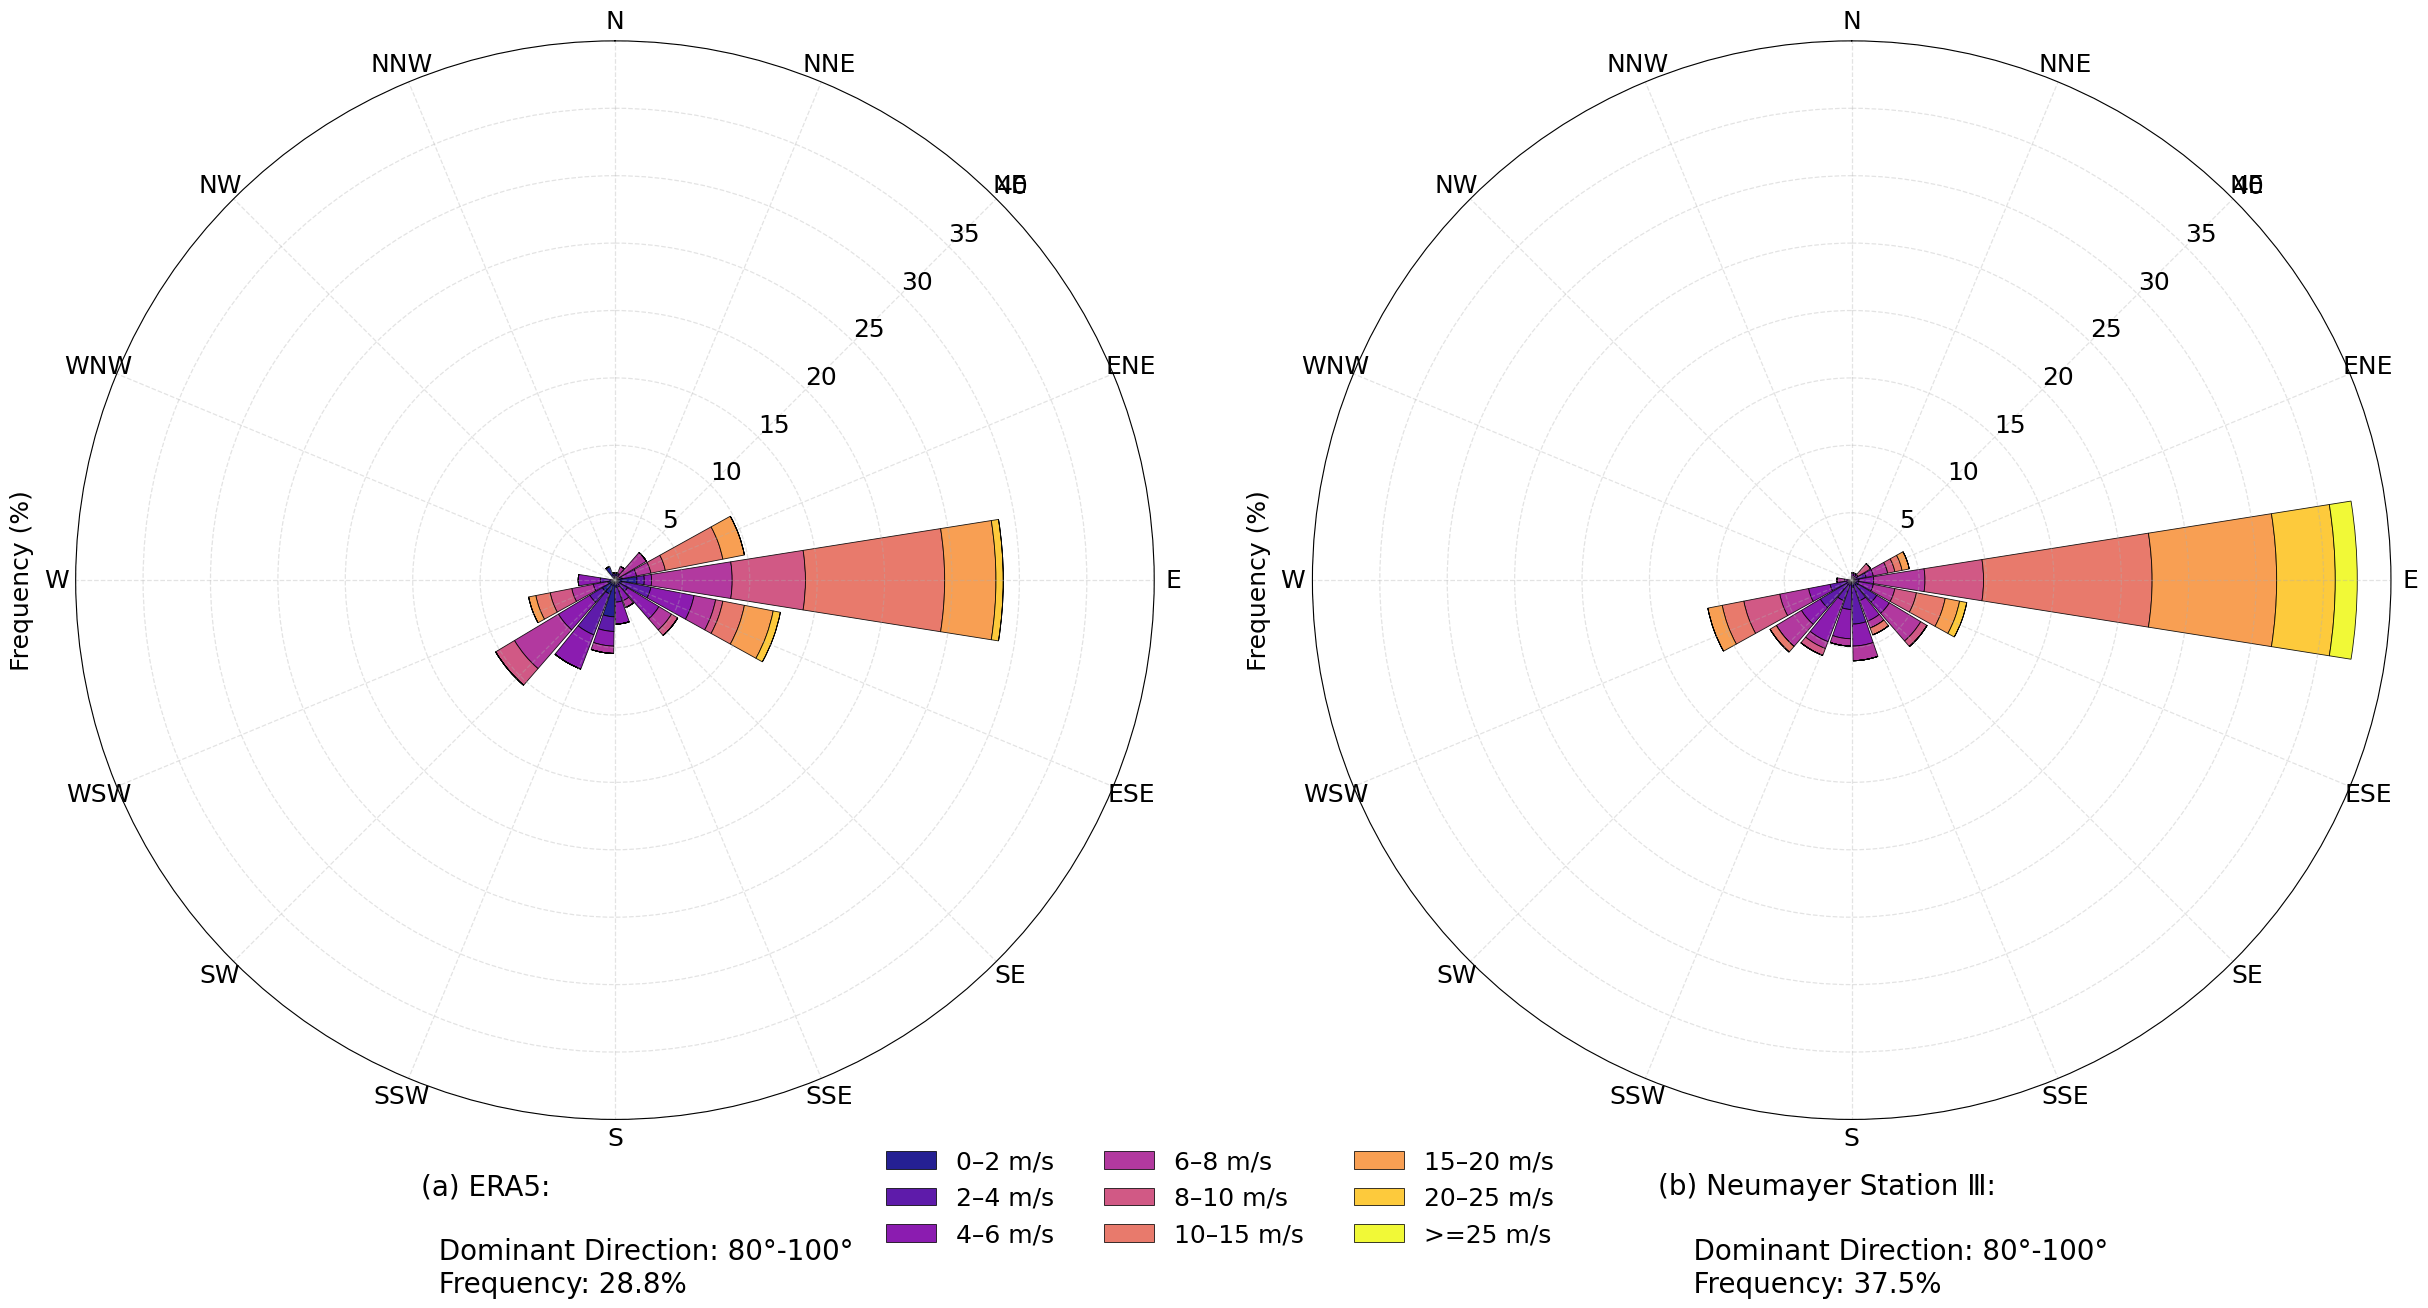

In [45]:
# ====== Plot======
txt_left = """(a) ERA5:

  Dominant Direction: 80°-100°
  Frequency: 28.8%"""

txt_right = """(b) Neumayer Station Ⅲ:

    Dominant Direction: 80°-100°
    Frequency: 37.5%"""

fig, axes = compare_wind_roses_big(mean_direction_correctted, mean_speed, direction_vecmean_NM, wind_speed_NM,
                               speed_bins=[0,2,4,6,8,10,15,20,25,30],
                               titles=(txt_left, txt_right))

# Layout adjustment
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # make space for legend
plt.show()


In [46]:
# fig.savefig("wind_rose_diagram.png", dpi=300, bbox_inches="tight")